In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
from torchvision.utils import make_grid
from PIL import Image
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install kaggle
!mkdir .kaggle
!mv kaggle.json .kaggle
!mv .kaggle /root/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download -d trolukovich/food5k-image-dataset

 98% 416M/426M [00:02<00:00, 156MB/s]
100% 426M/426M [00:03<00:00, 149MB/s]


In [ ]:
!unzip food5k*
!mkdir food
!mv ev* tr* vali* food

Streaming output truncated to the last 5000 lines.
  inflating: evaluation/food/0.jpg   
  inflating: evaluation/food/1.jpg   
  inflating: evaluation/food/10.jpg  
  inflating: evaluation/food/100.jpg  
  inflating: evaluation/food/101.jpg  
  inflating: evaluation/food/102.jpg  
  inflating: evaluation/food/103.jpg  
  inflating: evaluation/food/104.jpg  
  inflating: evaluation/food/105.jpg  
  inflating: evaluation/food/106.jpg  
  inflating: evaluation/food/107.jpg  
  inflating: evaluation/food/108.jpg  
  inflating: evaluation/food/109.jpg  
  inflating: evaluation/food/11.jpg  
  inflating: evaluation/food/110.jpg  
  inflating: evaluation/food/111.jpg  
  inflating: evaluation/food/112.jpg  
  inflating: evaluation/food/113.jpg  
  inflating: evaluation/food/114.jpg  
  inflating: evaluation/food/115.jpg  
  inflating: evaluation/food/116.jpg  
  inflating: evaluation/food/117.jpg  
  inflating: evaluation/food/118.jpg  
  inflating: evaluation/food/119.jpg  
  inflating: eval

In [ ]:
path = "./food"
file_names = []
for folder, subfolders, files, in os.walk(path):
  for file_name in files:
    file_names.append(folder + "/" + file_name)

print(len(file_names))

5000


In [ ]:
def display_image(img_file):
  sample_img = Image.open(img_file)
  display(sample_img)
  print(sample_img.size)

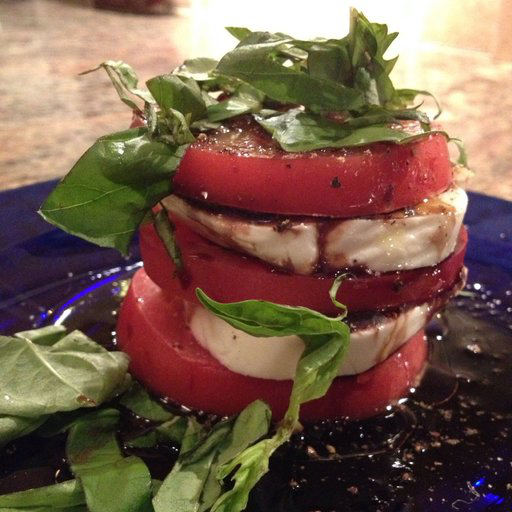

In [ ]:
display_image(file_names[210])

In [ ]:
file_sizes = []
for item in file_names:
  with Image.open(item) as img:
    file_sizes.append(img.size)

print(len(file_sizes))

(512, 512)
5000


In [ ]:
df = pd.DataFrame(file_sizes, columns=['width', 'height'])
df.head()

,width,height
0,512,512
1,382,512
2,512,512
3,512,512
4,512,384


In [ ]:
print(df['width'].describe(), '\n')
print(df['height'].describe())

count    5000.00000
mean      599.79680
std       313.97287
min       160.00000
25%       500.00000
50%       512.00000
75%       640.00000
max      4992.00000
Name: width, dtype: float64 

count    5000.000000
mean      529.970600
std       247.203085
min       120.000000
25%       384.000000
50%       512.000000
75%       512.000000
max      3328.000000
Name: height, dtype: float64


In [ ]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),  
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224),     
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [ ]:
train_data = datasets.ImageFolder(os.path.join(path, 'training'), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join(path, 'validation'), transform=test_transform)
test_data = datasets.ImageFolder(os.path.join(path, 'evaluation'), transform=test_transform)


train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

label_names = train_data.classes

print(label_names)

['food', 'non_food']


In [ ]:
print(len(train_data), len(val_data), len(test_data))

3000 1000 1000


food


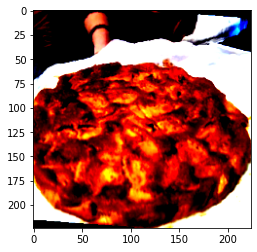

In [ ]:
plt.imshow(np.transpose(train_data[12][0].numpy(), (1,2,0)))
print (label_names[train_data[12][1]])

['food', 'food', 'non_food', 'food', 'food', 'non_food', 'food', 'food', 'food', 'non_food']


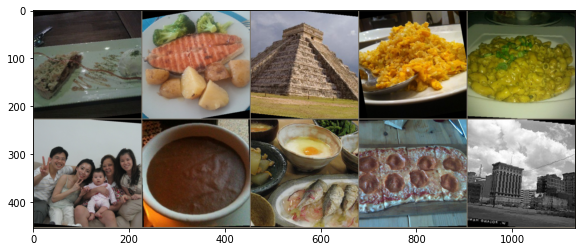

In [ ]:
for images,labels in train_loader: 
    break

im = make_grid(images, nrow=5)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))
print([label_names[index] for index in labels])

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
epochs = 3

train_list_losses = []
train_list_correct = []

val_list_losses = []
val_list_correct = []

for i in range(epochs):
    corr_no_train = 0
    corr_no_val = 0
    
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no +=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        corr_no_train += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no%100 == 0:
            print(f'epoch: {i}  batch: {batch_no} [{10*batch_no}/{len(train_data)}]  loss: {loss.item()} accuracy: {corr_no_train.item()*100/(10 * batch_no)}%')

    train_list_losses.append(loss)
    train_list_correct.append(corr_no_train)

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(val_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1] 
            corr_no_val += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    val_list_losses.append(loss)
    val_list_correct.append(corr_no_val)

epoch: 0  batch: 100 [1000/3000]  loss: 0.31606215238571167 accuracy: 90.8%
epoch: 0  batch: 200 [2000/3000]  loss: 0.1759546548128128 accuracy: 89.9%
epoch: 0  batch: 300 [3000/3000]  loss: 0.17433908581733704 accuracy: 89.7%
epoch: 1  batch: 100 [1000/3000]  loss: 0.1623297929763794 accuracy: 89.4%
epoch: 1  batch: 200 [2000/3000]  loss: 0.04946161434054375 accuracy: 89.7%
epoch: 1  batch: 300 [3000/3000]  loss: 0.2274654358625412 accuracy: 90.16666666666667%
epoch: 2  batch: 100 [1000/3000]  loss: 0.20987316966056824 accuracy: 90.4%
epoch: 2  batch: 200 [2000/3000]  loss: 0.2043207436800003 accuracy: 90.2%
epoch: 2  batch: 300 [3000/3000]  loss: 0.667763352394104 accuracy: 90.13333333333334%


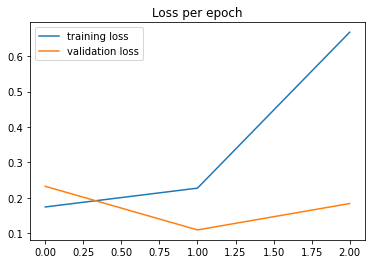

In [ ]:
with torch.no_grad():
  plt.plot(train_list_losses, label='training loss')
  plt.plot(val_list_losses, label='validation loss')
  plt.title('Loss per epoch')
  plt.legend();

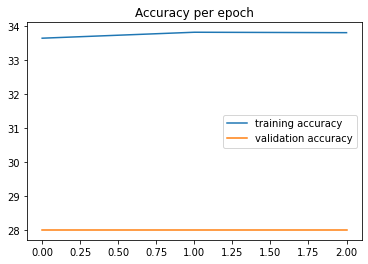

In [ ]:
with torch.no_grad():
  plt.plot([t/80 for t in train_list_correct], label='training accuracy')
  plt.plot([t/30 for t in val_list_correct], label='validation accuracy')
  plt.title('Accuracy per epoch')
  plt.legend();

In [ ]:
with torch.no_grad():
    correct_no = 0
    for X_test, y_test in test_loader:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct_no += (predicted == y_test).sum()
print(f'Accuracy (Test): {correct_no.item()}/{len(test_data)} = {correct_no.item()*100/(len(test_data))}%')

Accuracy (Test): 829/1000 = 82.9%


In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[359  30]
 [141 470]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f'Precision: {precision_score(y_test, predicted)}')
print(f'Recall: {recall_score(y_test, predicted)}')
print(f'Accuracy: {accuracy_score(y_test, predicted)}')
print(f'F1 Score: {f1_score(y_test, predicted)}')

Precision: 0.7692307692307693
Recall: 0.94
Accuracy: 0.829
F1 Score: 0.8460846084608461


# Using Pretrained network (AlexNet)

In [ ]:
from torchvision import datasets, transforms, models
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [ ]:
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Linear(512, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [ ]:
epochs = 4

train_list_losses_alex = []
train_list_correct_alex = []

val_list_losses_alex = []
val_list_correct_alex = []

for i in range(epochs):
    corr_no_train = 0
    corr_no_val = 0
    
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no +=1
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        corr_no_train += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no%100 == 0:
            print(f'epoch: {i}  batch: {batch_no} [{10*batch_no}/{len(train_data)}]  loss: {loss.item()} accuracy: {corr_no_train.item()*100/(10 * batch_no)}%')

    train_list_losses_alex.append(loss)
    train_list_correct_alex.append(corr_no_train)

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(val_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1] 
            corr_no_val += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    val_list_losses_alex.append(loss)
    val_list_correct_alex.append(corr_no_val)

epoch: 0  batch: 100 [1000/3000]  loss: 0.2853184640407562 accuracy: 90.3%
epoch: 0  batch: 200 [2000/3000]  loss: 0.5758909583091736 accuracy: 90.15%
epoch: 0  batch: 300 [3000/3000]  loss: 0.4704459607601166 accuracy: 90.26666666666667%
epoch: 1  batch: 100 [1000/3000]  loss: 0.20184457302093506 accuracy: 90.6%
epoch: 1  batch: 200 [2000/3000]  loss: 0.09453999251127243 accuracy: 90.25%
epoch: 1  batch: 300 [3000/3000]  loss: 0.42045146226882935 accuracy: 90.23333333333333%
epoch: 2  batch: 100 [1000/3000]  loss: 0.13543491065502167 accuracy: 90.1%
epoch: 2  batch: 200 [2000/3000]  loss: 0.30644163489341736 accuracy: 89.85%
epoch: 2  batch: 300 [3000/3000]  loss: 0.33263254165649414 accuracy: 89.5%
epoch: 3  batch: 100 [1000/3000]  loss: 0.24595871567726135 accuracy: 89.8%
epoch: 3  batch: 200 [2000/3000]  loss: 0.17548276484012604 accuracy: 89.85%
epoch: 3  batch: 300 [3000/3000]  loss: 0.17910750210285187 accuracy: 89.63333333333334%


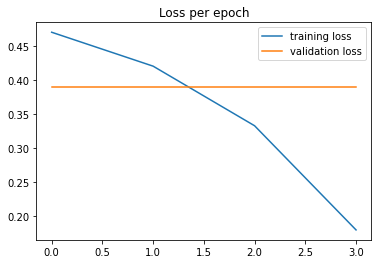

In [ ]:
with torch.no_grad():
  plt.plot(train_list_losses_alex, label='training loss')
  plt.plot(val_list_losses_alex, label='validation loss')
  plt.title('Loss per epoch')
  plt.legend();

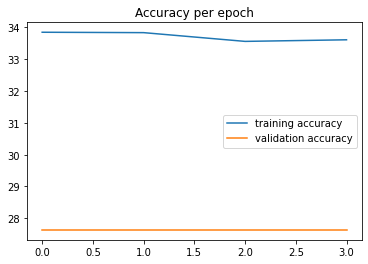

In [ ]:
with torch.no_grad():
  plt.plot([t/80 for t in train_list_correct_alex], label='training accuracy')
  plt.plot([t/30 for t in val_list_correct_alex], label='validation accuracy')
  plt.title('Accuracy per epoch')
  plt.legend();

In [ ]:
AlexNetmodel.eval()
with torch.no_grad():
    correct_no = 0
    for X_test, y_test in test_loader:
        y_val = AlexNetmodel(X_test)
        predicted = torch.max(y_val,1)[1]
        correct_no += (predicted == y_test).sum()
print(f'Accuracy (Test): {correct_no.item()}/{len(test_data)} = {correct_no.item()*100/(len(test_data))}%')

Accuracy (Test): 476/1000 = 47.6%


In [ ]:
x = 229
AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(new_pred)
print(f'Predicted value: {new_pred.item()} {label_names[new_pred.item()]}')

tensor(0)
Predicted value: 0 food


In [ ]:
test_data[x][0].shape

torch.Size([3, 224, 224])

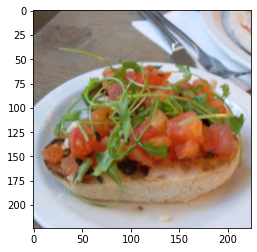

In [ ]:
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1,2,0)))